In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
from PIL import Image
from keras.preprocessing import image
import os
import numpy as np
import pandas as pd
from subprocess import check_output
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib

      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1
1664


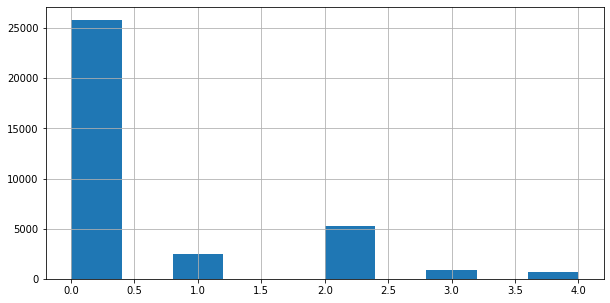

In [7]:
trainpath = "/content/gdrive/My Drive/diabeticdata/train/"
labelpath = "/content/gdrive/My Drive/diabeticdata/trainLabels.csv"
trainLabels = pd.read_csv(labelpath)
print(trainLabels.head())
listing = os.listdir(trainpath)
print(np.size(listing))
trainLabels['level'].hist(figsize=(10,5))

In [11]:
img_rows, img_cols = 224, 224
immatrix = []
imlabel = []

for file in listing:
    base = os.path.basename(trainpath + file)  
    fileName = os.path.splitext(base)[0]
    imlabel.append(trainLabels.loc[trainLabels.image==fileName, 'level'].values[0])
    im = Image.open(trainpath + file)
    img = im.resize((img_rows,img_cols))
    img = np.array(img)
    img[:,:,0] = img[:,:,0]-103.939
    img[:,:,1]=img[:,:,0]-116.779
    img[:,:,2]=img[:,:,0]-123.68
   # immatrix.append(np.array(img))
    immatrix.append(img)

In [12]:
from collections import Counter
print(Counter(imlabel))

Counter({0: 1226, 2: 261, 1: 104, 3: 39, 4: 34})


In [13]:
# 훈련과 테스트 데이터 셋 생성
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(immatrix, imlabel, test_size = 0.2, random_state = 42, stratify=imlabel)

print(np.array(x_train).shape)
print(np.array(y_train).shape)
print(np.array(x_test).shape)
print(np.array(y_test).shape)
print(Counter(y_train))
print(Counter(y_test))

(1331, 224, 224, 3)
(1331,)
(333, 224, 224, 3)
(333,)
Counter({0: 981, 2: 209, 1: 83, 3: 31, 4: 27})
Counter({0: 245, 2: 52, 1: 21, 3: 8, 4: 7})


In [14]:
# One-Hot Encoding
from keras.utils import np_utils

y_train = np_utils.to_categorical(np.array(y_train),5)
y_test = np_utils.to_categorical(np.array(y_test), 5)

print(np.array(x_train).shape)
print(np.array(x_test).shape)
print(np.array(y_train).shape)
print(np.array(y_test).shape)

(1331, 224, 224, 3)
(333, 224, 224, 3)
(1331, 5)
(333, 5)


In [15]:
# CNN 모델 생성
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

def createModel(LR, EPOCHS, NUM_CLASSES, inputShape):
    model = Sequential()
    # first set of CONV => RELU => MAX POOL layers
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=inputShape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(activation='softmax', units=NUM_CLASSES))    
    opt = Adam(lr=LR, decay=LR/ EPOCHS)    
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

In [16]:
lr = 0.0001
epochs = 10
classnum = 5
print(x_train[0].shape)
cnnmodel = createModel(lr, epochs, classnum,x_train[0].shape)
cnnmodel.summary()

(224, 224, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 

In [25]:
# 클래스의 불균형 해소를 위한 over-sampling
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
Xtrain = np.array(x_train)
xTrain = Xtrain.reshape(len(Xtrain), img_rows*img_cols*3 )
print(xTrain.shape)
x_smote, y_smote = sm.fit_resample(xTrain, y_train)

(1331, 150528)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [52]:
import tensorflow as tf
y_smote=np.array(y_smote)
y_smote = y_smote.reshape(-1,5)
print(y_smote.shape)
count_label = tf.reduce_sum(y_smote, axis=0)
print(count_label)
x_smote = np.array(x_smote)
x_smote = x_smote.reshape(-1,img_rows, img_cols, 3)
print(x_smote.shape)


(4905, 5)
tf.Tensor([981 981 981 981 981], shape=(5,), dtype=int64)
(4905, 224, 224, 3)


In [45]:
cnnmodel.fit(x_smote, y_smote, batch_size = 64, epochs=10, shuffle=True, verbose=2)

Epoch 1/10
 - 46s - loss: 7.2576 - accuracy: 0.2027
Epoch 2/10
 - 35s - loss: 1.6094 - accuracy: 0.2043
Epoch 3/10
 - 35s - loss: 1.6082 - accuracy: 0.2186
Epoch 4/10
 - 35s - loss: 1.6096 - accuracy: 0.2124
Epoch 5/10
 - 35s - loss: 1.6106 - accuracy: 0.2098
Epoch 6/10
 - 35s - loss: 1.6084 - accuracy: 0.2133
Epoch 7/10
 - 35s - loss: 1.6072 - accuracy: 0.2151
Epoch 8/10
 - 35s - loss: 1.6059 - accuracy: 0.2183
Epoch 9/10
 - 35s - loss: 1.6030 - accuracy: 0.2245
Epoch 10/10
 - 35s - loss: 1.6025 - accuracy: 0.2353
